# NumTopics: all datasets

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import itertools
import os
import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.dataset import Dataset

In [3]:
sys.path.insert(0, '../..')
sys.path.insert(0, '..')


from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods.optimize_scores_method import OptimizeScoresMethod
from topnum.utils import (
    read_corpus_config, split_into_train_test, 
    build_every_score, monotonity_and_std_analysis, 
    trim_config, plot_everything_informative
)
from topnum.model_constructor import KnownModel, PARAMS_EXPLORED
from topnum.utils import estimate_num_iterations_for_convergence

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Experiments

In [5]:
configs_dir = os.path.join('..', 'topnum', 'configs')
configs_mask = os.path.join(configs_dir, '*.yml')


for config_file in glob.glob(configs_mask):
    config = read_corpus_config(config_file)

    print(config['name'], config_file)

StackOverflow ../topnum/configs/SO.yml
RuWikiGood ../topnum/configs/ruwikigood.yml
Brown ../topnum/configs/Brown.yml
Reuters ../topnum/configs/Reuters.yml
WikiRef220 ../topnum/configs/WikiRef220.yml
PostNauka ../topnum/configs/PN.yml
20NewsGroups ../topnum/configs/20NG.yml


In [6]:
config

OrderedDict([('name', '20NewsGroups'),
             ('batches_prefix', '20NG'),
             ('dataset_path',
              '/data_mil/datasets/20_News_dataset/20NG_BOW.csv'),
             ('word', '@word'),
             ('min_num_topics', 10),
             ('max_num_topics', 30),
             ('num_topics_interval', 3),
             ('num_fit_iterations', 40),
             ('num_restarts', 3)])

In [8]:
# for debug

config = read_corpus_config(configs_dir + "/WikiRef220.yml")

config['num_restarts'] = 1
config['num_fit_iterations'] = 5
config['num_topics_interval'] = 5

In [9]:
dataset = Dataset(
    config['dataset_path'], 
    internals_folder_path=f'/home/vbulatov/Projects/OptimalNumberOfTopics/demos/{config["batches_prefix"]}_internals'
)

In [ ]:
MIN_DF_RATE = 0.001

In [ ]:
train_dataset, test_dataset = split_into_train_test(dataset, config)

for d in [train_dataset, test_dataset]:
    d._cached_dict = d.get_dictionary().filter(min_df_rate=MIN_DF_RATE)

In [ ]:
text_collection = VowpalWabbitTextCollection.from_dataset(
    train_dataset, main_modality=config['word']
)

In [ ]:
text_collection._to_dataset().get_dictionary()

In [10]:
experiment_name_template = "shy_test_{}_{}"
experiment_directory=f"/data_mil/vbulatov/{config['batches_prefix']}"


for model_family in KnownModel:
    template = PARAMS_EXPLORED[model_family]

    the_grid = [
            [[key, one_value] for one_value in template[key]]
            for key, params in template.items()
    ]
    
    print(model_family)
    
    for idx, model_params in enumerate(itertools.product(*the_grid)):

        print(model_params)
        
        lst = [x for x in zip(*model_params)]
        if len(lst):
            model_params = dict(zip(lst[0], lst[1]))
        else: 
            model_params = {}
        
        print(model_params)
        
        experiment_name = experiment_name_template.format(model_family.value, idx)
        built_scores = build_every_score(train_dataset, test_dataset, config)
        optimizer = OptimizeScoresMethod(
            scores=built_scores,
            model_family=model_family,
            experiment_name=experiment_name,
            experiment_directory=experiment_directory,
            one_model_num_processors=6,
            model_params=model_params,
            **trim_config(config, OptimizeScoresMethod)
        )
        
        t_start = time.time()

        optimizer.search_for_optimum(text_collection)
        
        t_end = time.time()
        
        print(model_family, (t_end - t_start) / 60 / 60)

  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA
(['prior', 'symmetric'],)
{'prior': 'symmetric'}
{'prior': 'symmetric'} 2 None 6
{'prior': 'symmetric'} 7 None 6
{'prior': 'symmetric'} 12 None 6
{'prior': 'symmetric'} 17 None 6


100%|██████████| 1/1 [00:47<00:00, 47.26s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.013350360459751553
(['prior', 'small'],)
{'prior': 'small'}
{'prior': 'small'} 2 None 6
{'prior': 'small'} 7 None 6
{'prior': 'small'} 12 None 6
{'prior': 'small'} 17 None 6


100%|██████████| 1/1 [00:47<00:00, 47.20s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.013212286631266276
(['prior', 'heuristic'],)
{'prior': 'heuristic'}
{'prior': 'heuristic'} 2 None 6
{'prior': 'heuristic'} 7 None 6
{'prior': 'heuristic'} 12 None 6
{'prior': 'heuristic'} 17 None 6


100%|██████████| 1/1 [00:47<00:00, 47.51s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.LDA 0.013302172886000739
KnownModel.PLSA
()
{}
{} 2 None 6
{} 7 None 6
{} 12 None 6
{} 17 None 6


100%|██████████| 1/1 [00:47<00:00, 47.05s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.PLSA 0.013173134260707431
KnownModel.SPARSE
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.57s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.014080055488480462
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.80s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.01414344482951694
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.52s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.014065854748090108
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.28s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.SPARSE 0.013996442026562162
KnownModel.DECORRELATION
(['decorrelation_tau', 0.02],)
{'decorrelation_tau': 0.02}
{'decorrelation_tau': 0.02} 2 None 6
{'decorrelation_tau': 0.02} 7 None 6
{'decorrelation_tau': 0.02} 12 None 6
{'decorrelation_tau': 0.02} 17 None 6


100%|██████████| 1/1 [00:47<00:00, 47.02s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.DECORRELATION 0.013093593915303547
(['decorrelation_tau', 0.05],)
{'decorrelation_tau': 0.05}
{'decorrelation_tau': 0.05} 2 None 6
{'decorrelation_tau': 0.05} 7 None 6
{'decorrelation_tau': 0.05} 12 None 6
{'decorrelation_tau': 0.05} 17 None 6


100%|██████████| 1/1 [00:46<00:00, 46.96s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.DECORRELATION 0.013076331549220615
(['decorrelation_tau', 0.1],)
{'decorrelation_tau': 0.1}
{'decorrelation_tau': 0.1} 2 None 6
{'decorrelation_tau': 0.1} 7 None 6
{'decorrelation_tau': 0.1} 12 None 6
{'decorrelation_tau': 0.1} 17 None 6


100%|██████████| 1/1 [00:46<00:00, 46.94s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.DECORRELATION 0.013069628543323941
KnownModel.ARTM
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.98s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014196647736761304
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.83s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01416291018327077
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.41s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014035498632325066
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.46s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014048713246981304
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.34s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014015795124901666
(['smooth_bcg_tau', 0.05], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1}
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 2 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 7 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 12 None 6
{'smooth_bcg_tau': 0.05, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.54s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01407097207175361
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.02} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.44s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014045034050941466
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.45s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.01404473536544376
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.05], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.05, 'decorrelation_tau': 0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.53s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014071432219611274
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.02])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.02} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.85s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014156830112139385
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.05])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.05} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.34s/it]
/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  0%|          | 0/1 [00:00<?, ?it/s]

KnownModel.ARTM 0.014013002382384405
(['smooth_bcg_tau', 0.1], ['sparse_sp_tau', -0.1], ['decorrelation_tau', 0.1])
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1}
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 2 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 7 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 12 None 6
{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1} 17 None 6


100%|██████████| 1/1 [00:50<00:00, 50.45s/it]

KnownModel.ARTM 0.014045454793506197



/home/vbulatov/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [11]:
PARAMS_EXPLORED

{<KnownModel.LDA: 'LDA'>: {'prior': ['symmetric', 'small', 'heuristic']},
 <KnownModel.PLSA: 'PLSA'>: {},
 <KnownModel.SPARSE: 'sparse'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1]},
 <KnownModel.DECORRELATION: 'decorrelation'>: {'decorrelation_tau': [0.02,
   0.05,
   0.1]},
 <KnownModel.ARTM: 'ARTM'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1],
  'decorrelation_tau': [0.02, 0.05, 0.1]}}

In [12]:
PARAMS_EXPLORED

{<KnownModel.LDA: 'LDA'>: {'prior': ['symmetric', 'small', 'heuristic']},
 <KnownModel.PLSA: 'PLSA'>: {},
 <KnownModel.SPARSE: 'sparse'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1]},
 <KnownModel.DECORRELATION: 'decorrelation'>: {'decorrelation_tau': [0.02,
   0.05,
   0.1]},
 <KnownModel.ARTM: 'ARTM'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1],
  'decorrelation_tau': [0.02, 0.05, 0.1]}}

In [13]:
optimizer._model_params

{'smooth_bcg_tau': 0.1, 'sparse_sp_tau': -0.1, 'decorrelation_tau': 0.1}

In [14]:
config['dataset_path']

'/data_mil/datasets/WikiRef220/wiki_ref220_bow.csv'

In [15]:
PARAMS_EXPLORED

{<KnownModel.LDA: 'LDA'>: {'prior': ['symmetric', 'small', 'heuristic']},
 <KnownModel.PLSA: 'PLSA'>: {},
 <KnownModel.SPARSE: 'sparse'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1]},
 <KnownModel.DECORRELATION: 'decorrelation'>: {'decorrelation_tau': [0.02,
   0.05,
   0.1]},
 <KnownModel.ARTM: 'ARTM'>: {'smooth_bcg_tau': [0.05, 0.1],
  'sparse_sp_tau': [-0.05, -0.1],
  'decorrelation_tau': [0.02, 0.05, 0.1]}}

In [19]:
all_models_mask = os.path.join(experiment_directory, experiment_name_template.format("*", "*"), "*")

for entry in glob.glob(all_models_mask):
    print(entry)
    tm = TopicModel.load(entry)
    print(len(tm.topic_names), estimate_num_iterations_for_convergence(tm))



/data_mil/vbulatov/WRef_shy_test/shy_test_ARTM_6_None/2aefe8b7-0bce-4595-a1f2-e59b54ccc8a6
3 4
/data_mil/vbulatov/WRef_shy_test/shy_test_ARTM_6_None/a0a3b7b1-aa93-492d-8dc8-1b918407d9f8
18 4
/data_mil/vbulatov/WRef_shy_test/shy_test_ARTM_6_None/487a691a-dc6d-4c43-9004-010815d55433
8 4
/data_mil/vbulatov/WRef_shy_test/shy_test_ARTM_6_None/33603487-5066-43e8-a952-4f54074923da
13 4
/data_mil/vbulatov/WRef_shy_test/shy_test_sparse_1_None/2b1a5855-bcbe-4d58-a28b-5de2a41cbf19
8 4
/data_mil/vbulatov/WRef_shy_test/shy_test_sparse_1_None/4fb74313-4821-4a6e-9ace-dceea3b9b0e7
13 4
/data_mil/vbulatov/WRef_shy_test/shy_test_sparse_1_None/bef4366d-9d47-439b-bbf5-cae7a9605215
18 4
/data_mil/vbulatov/WRef_shy_test/shy_test_sparse_1_None/b8902783-fae7-4d5a-96b6-c6532ea5ba9b
3 4
/data_mil/vbulatov/WRef_shy_test/shy_test_LDA_1_None/2990c5b5-c690-430b-adba-29a2ed4a71a3
5 4
/data_mil/vbulatov/WRef_shy_test/shy_test_LDA_1_None/9577281a-eb96-4d78-8d10-cc1c77c4dffd
17 4
/data_mil/vbulatov/WRef_shy_test/shy_te

KeyboardInterrupt: 

In [40]:
monotonity_and_std_analysis(
    experiment_name_template=experiment_name_template,
    experiment_directory=experiment_directory,
)

shy_test_ARTM_6_None  \
PerplexityScore@all                                       True   
SparsityThetaScore                                        True   
SparsityPhiScore@lemmatized                               True   
PerplexityScore@lemmatized                                True   
TopicKernel@lemmatized.average_coherence                  True   
TopicKernel@lemmatized.average_contrast                  False   
TopicKernel@lemmatized.average_purity                     True   
TopicKernel@lemmatized.average_size                       True   
perp                                                      True   
sparsity_phi                                              True   
sparsity_theta                                            True   
holdout_perp                                              True   
arun                                                      True   
diversity_euclidean_True                                  True   
diversity_euclidean_False                                 True   
diversity_jensenshannon_True                             False   
diversity_jensenshannon_False                             True   
diversity_cosine_True                                    False   
diversity_cosine_False                                    True   
diversity_hellinger_True                                 False   
diversity_hellinger_False                                 True   
calhar                                                    True   
silh                                                      True   
renyi_0.5                                                False   
renyi_1                                                  False   
renyi_2                                                   True   
AIC_sparsity_True                                         True   
AIC_sparsity_False                                        True   
BIC_sparsity_True                                        False   
BIC_sparsity_False                                        True   
MDL_sparsity_True                                         True   
MDL_sparsity_False                                        True   
intra                                                     True   
toptok1                                                  False   

                                          shy_test_sparse_1_None  \
PerplexityScore@all                                         True   
SparsityThetaScore                                          True   
SparsityPhiScore@lemmatized                                 True   
PerplexityScore@lemmatized                                  True   
TopicKernel@lemmatized.average_coherence                    True   
TopicKernel@lemmatized.average_contrast                    False   
TopicKernel@lemmatized.average_purity                       True   
TopicKernel@lemmatized.average_size                         True   
perp                                                        True   
sparsity_phi                                                True   
sparsity_theta                                              True   
holdout_perp                                                True   
arun                                                       False   
diversity_euclidean_True                                   False   
diversity_euclidean_False                                  False   
diversity_jensenshannon_True                               False   
diversity_jensenshannon_False                              False   
diversity_cosine_True                                      False   
diversity_cosine_False                                     False   
diversity_hellinger_True                                   False   
diversity_hellinger_False                                   True   
calhar                                                      True   
silh                                                       False   
renyi_0.5                                                  False   
renyi_1                        

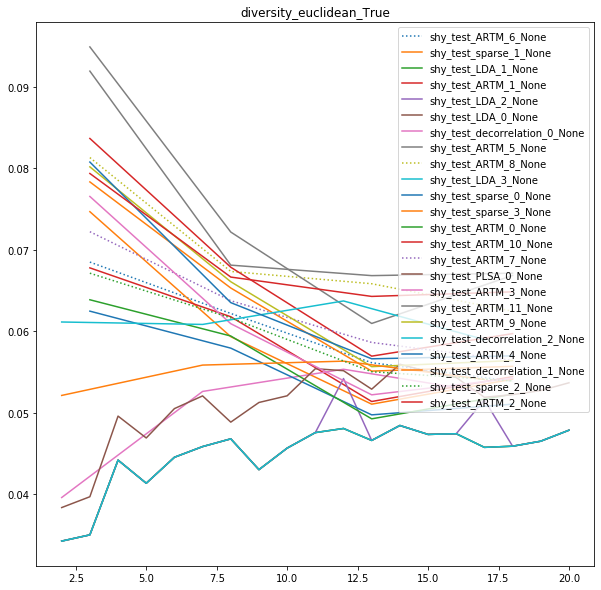

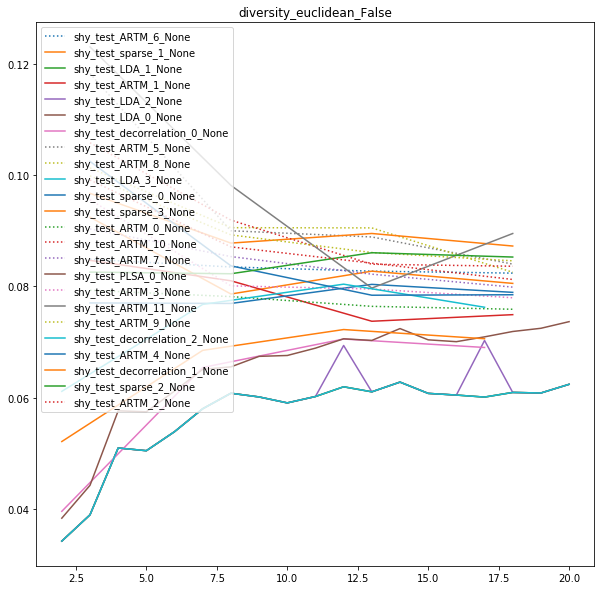

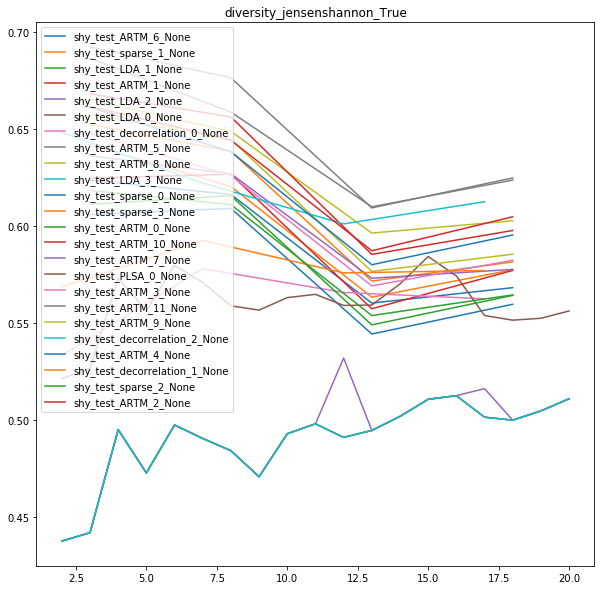

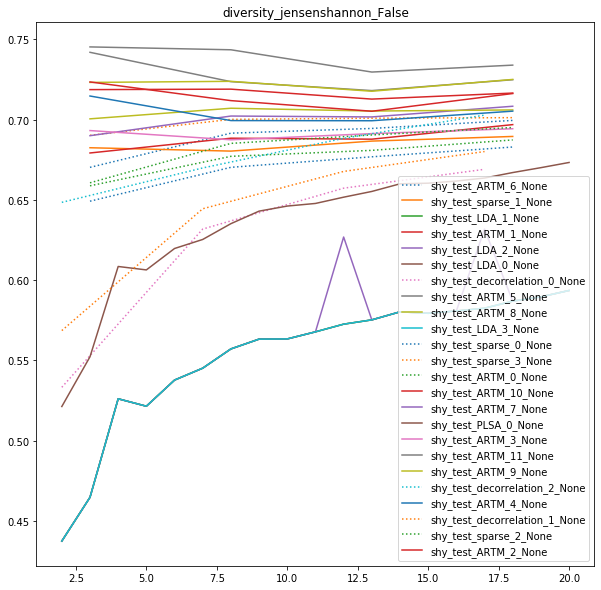

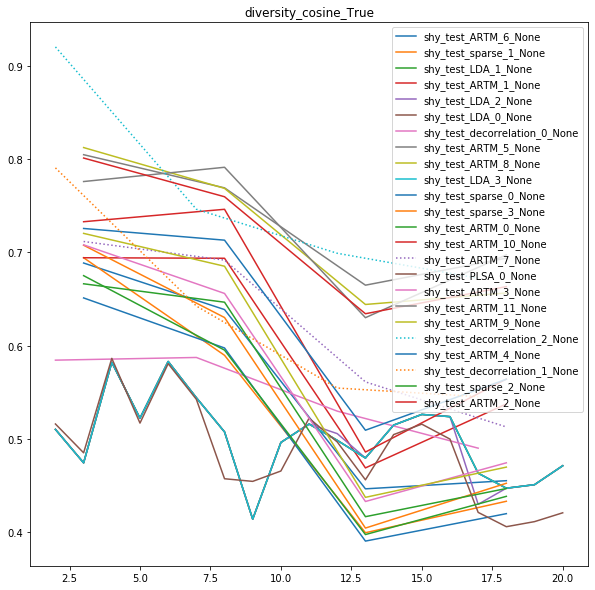

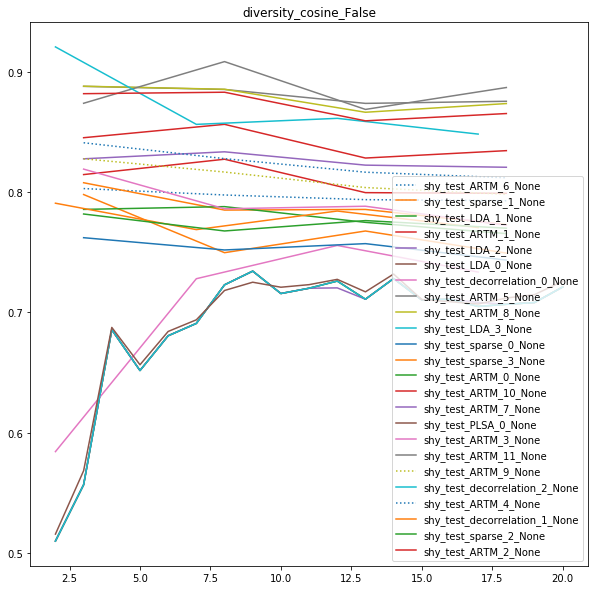

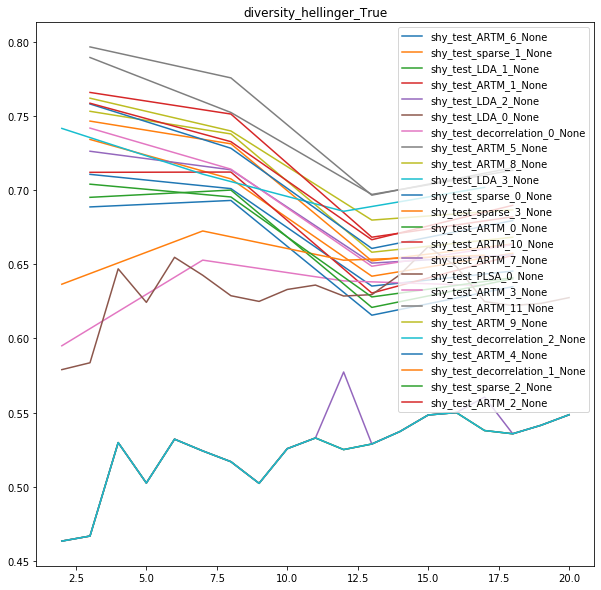

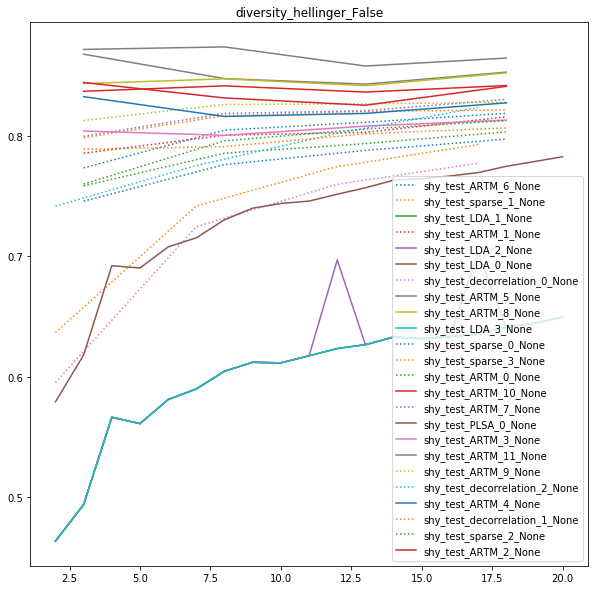

In [45]:

plot_everything_informative(experiment_directory, experiment_name_template, ["diversity"])


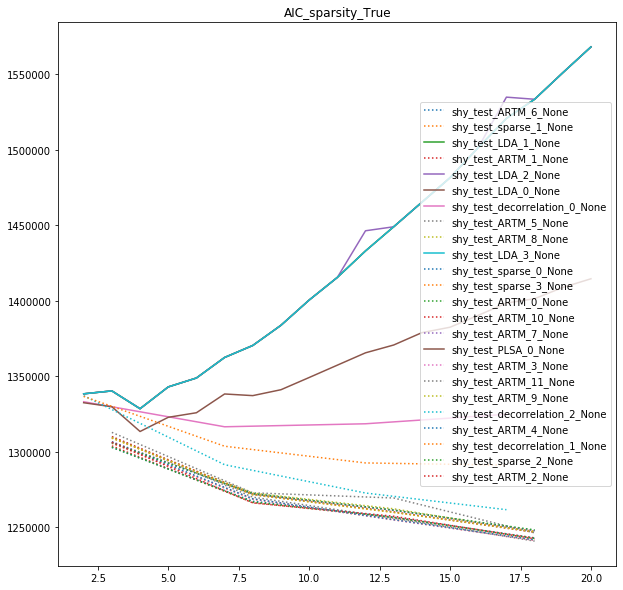

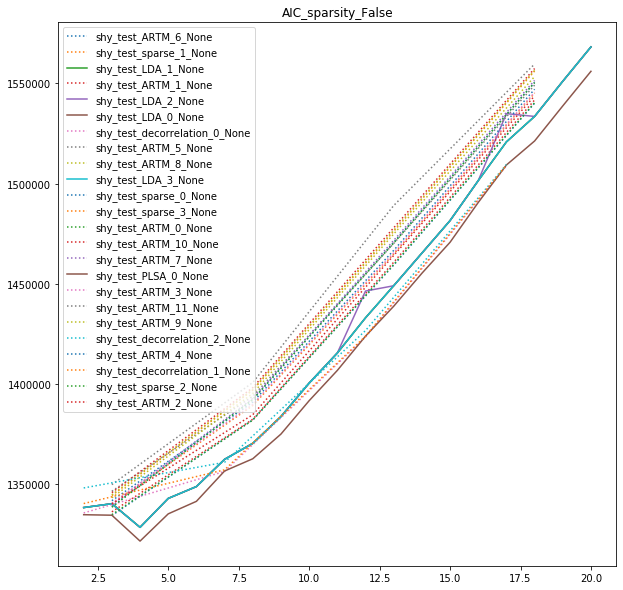

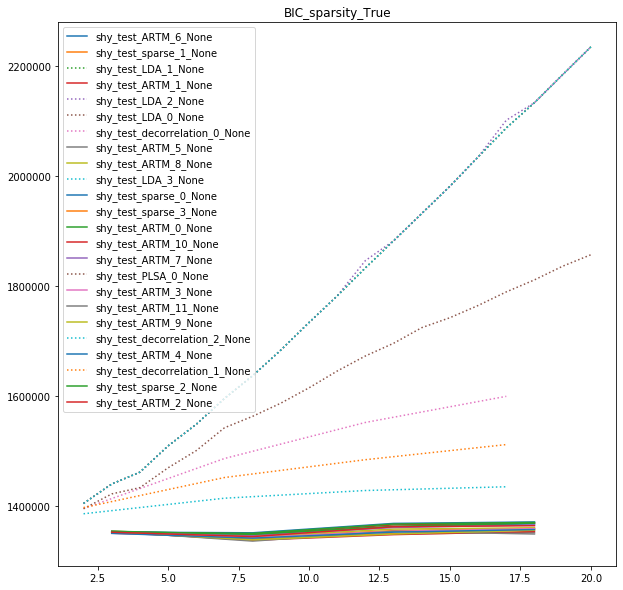

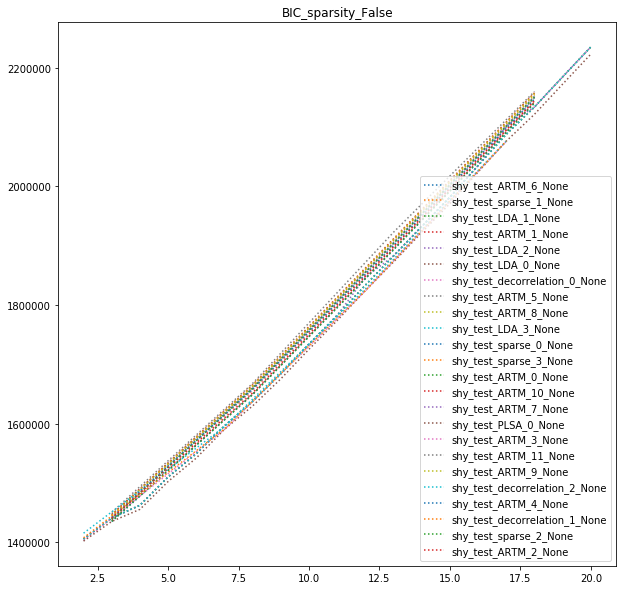

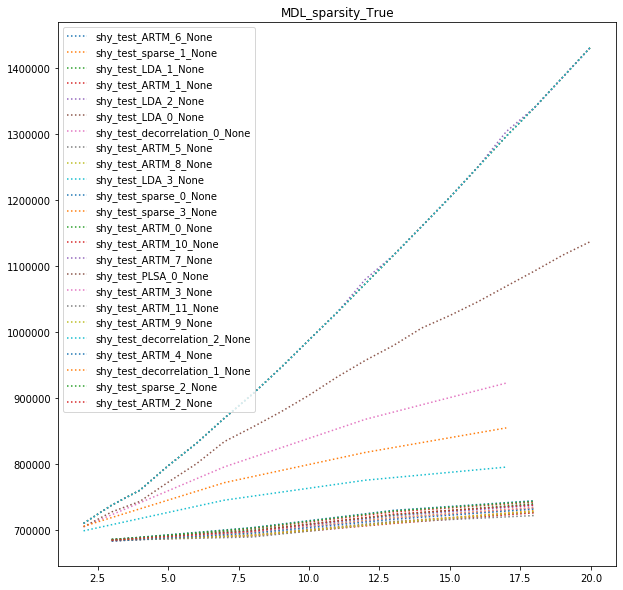

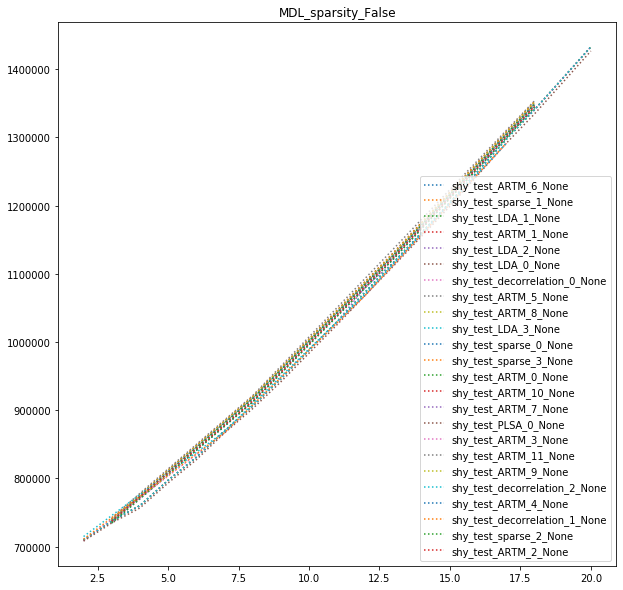

In [46]:
plot_everything_informative(experiment_directory, experiment_name_template, ["_sparsity"])


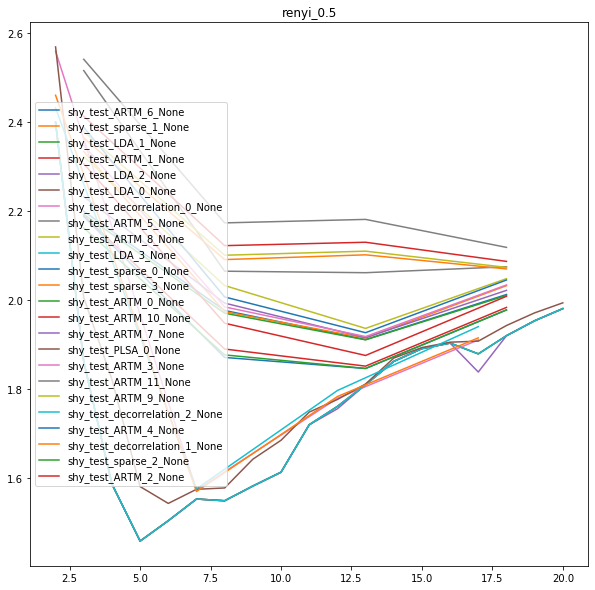

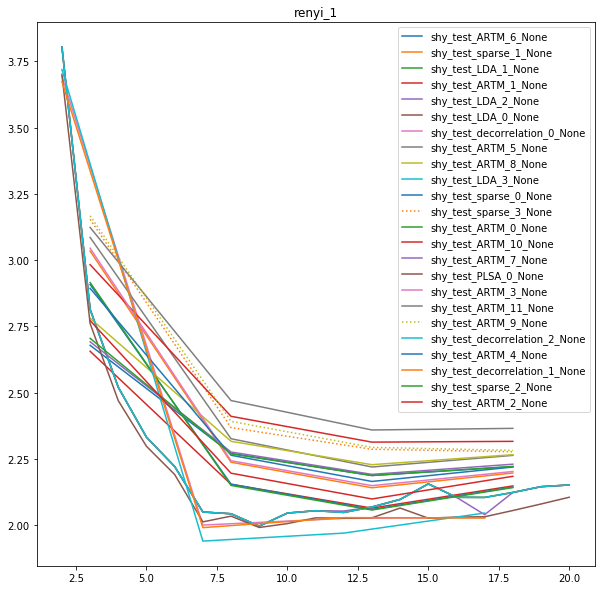

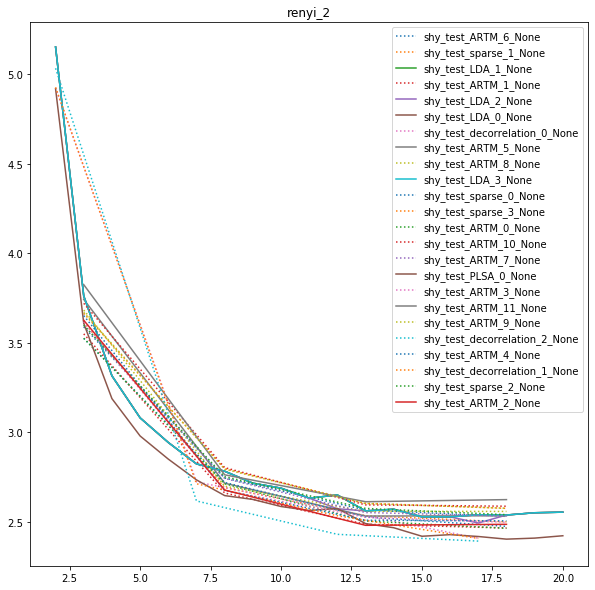

In [47]:
plot_everything_informative(experiment_directory, experiment_name_template, ['renyi'])


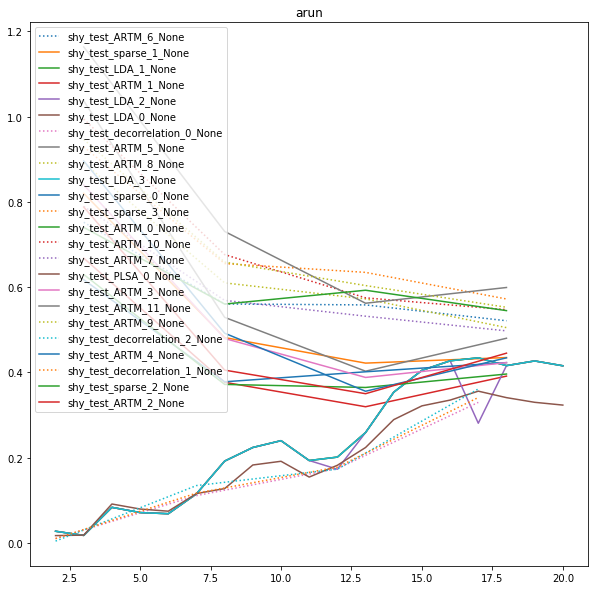

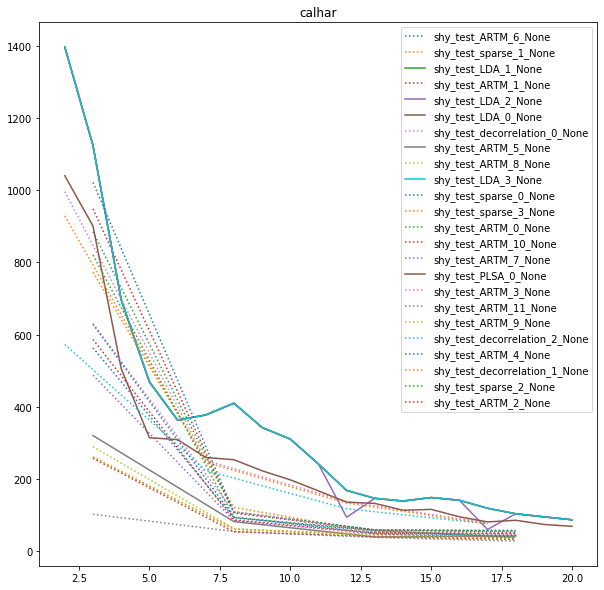

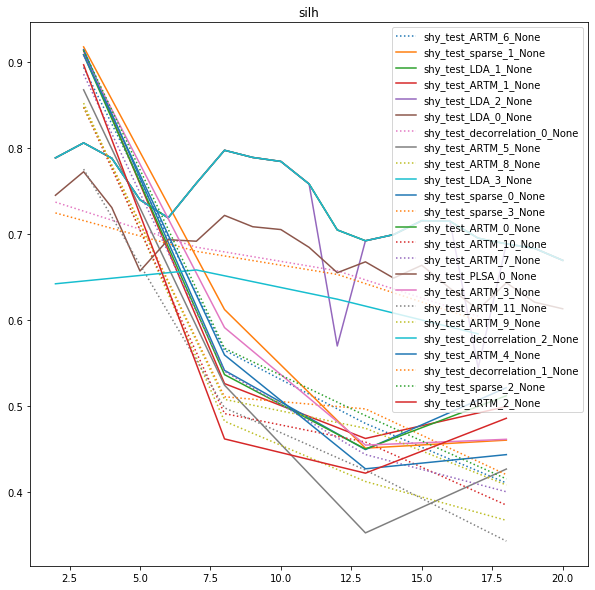

In [48]:
plot_everything_informative(experiment_directory, experiment_name_template, ['arun'])
plot_everything_informative(experiment_directory, experiment_name_template, ['calhar'])
plot_everything_informative(experiment_directory, experiment_name_template, ['silh'])


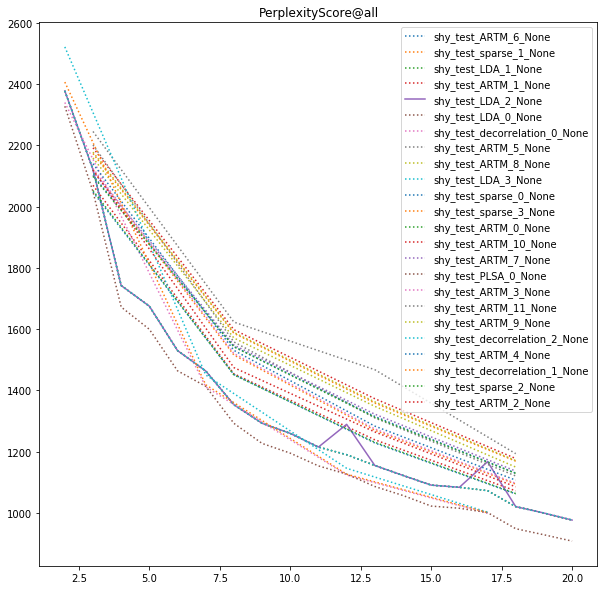

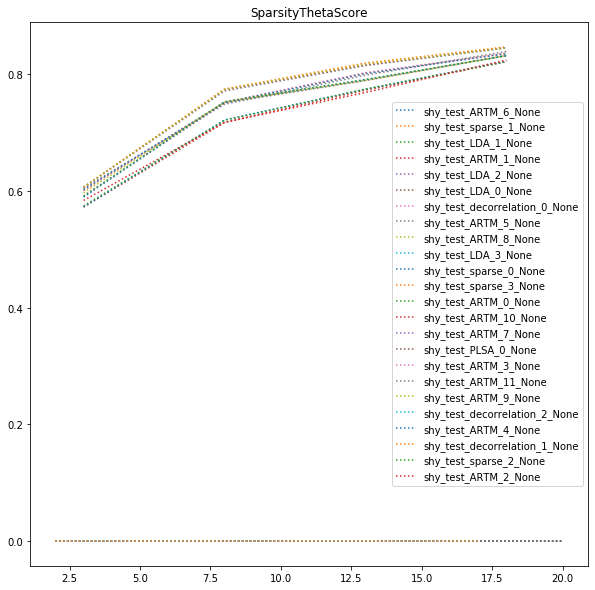

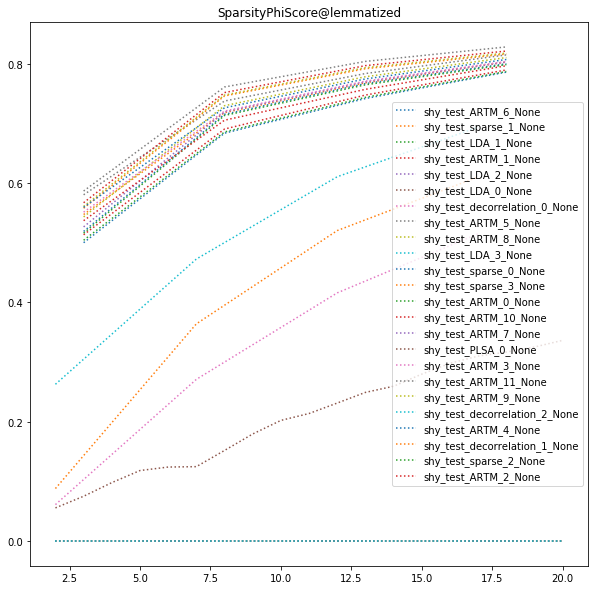

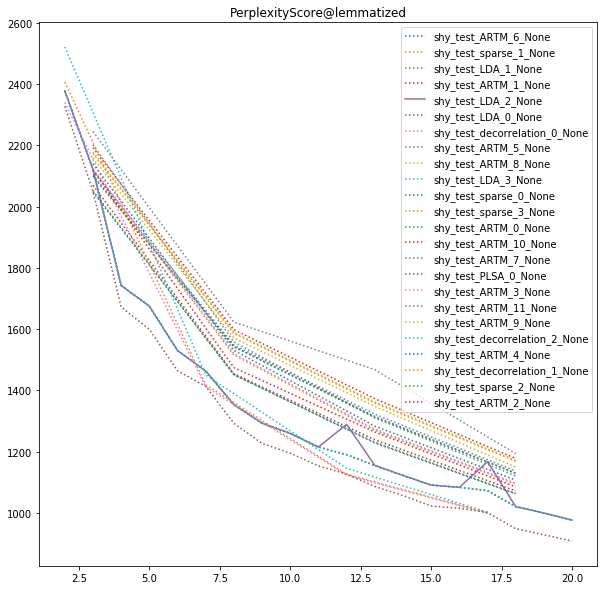

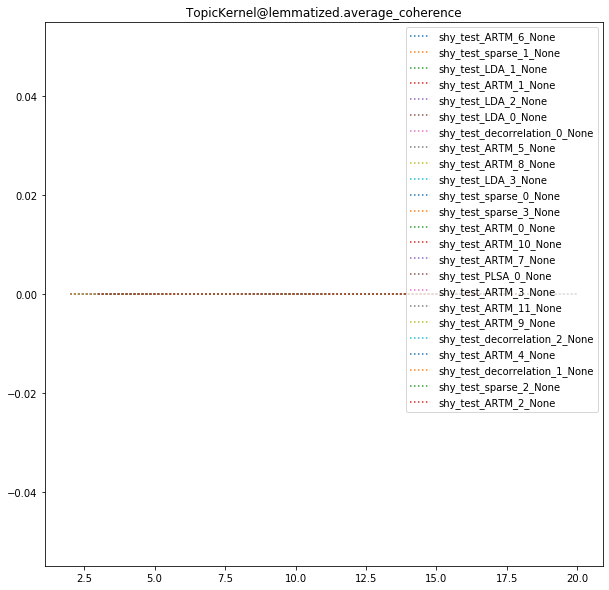

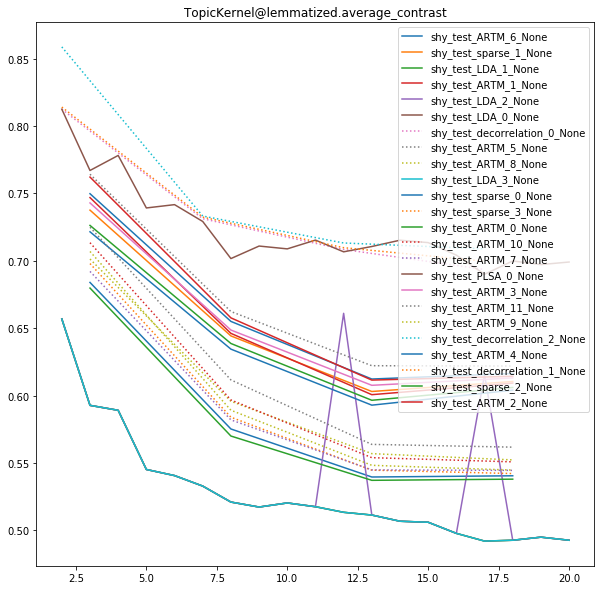

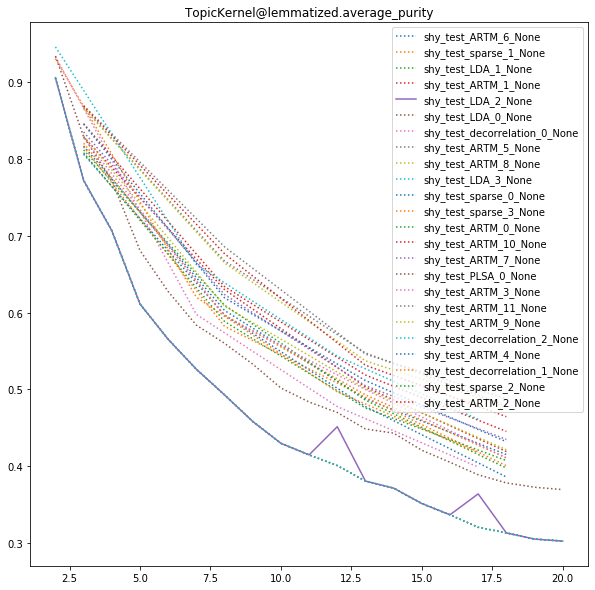

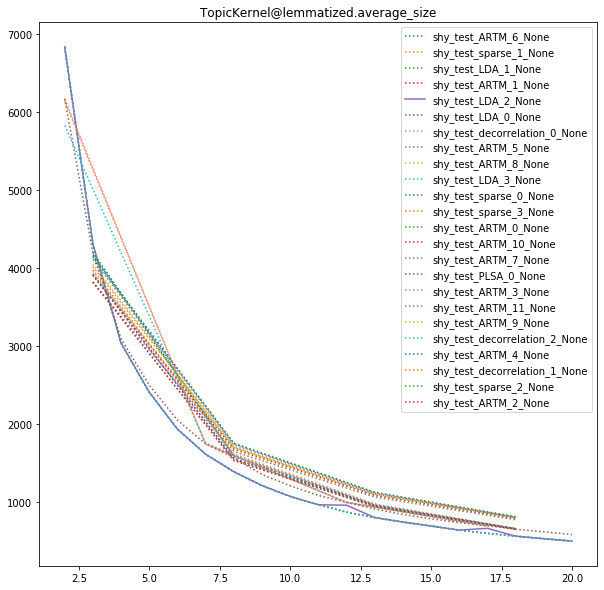

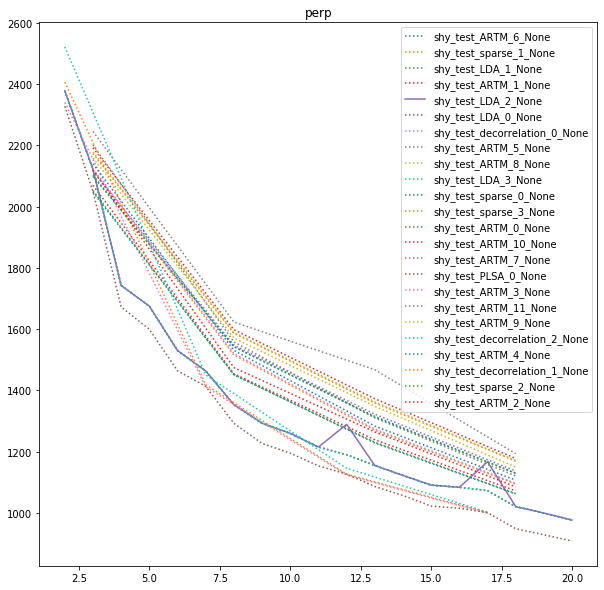

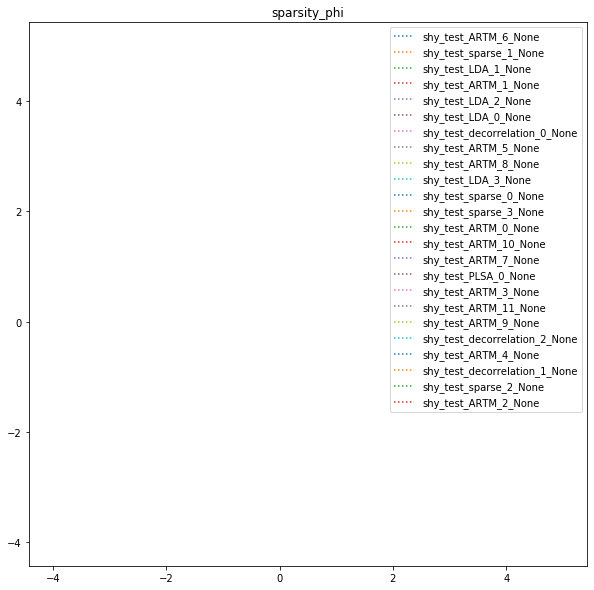

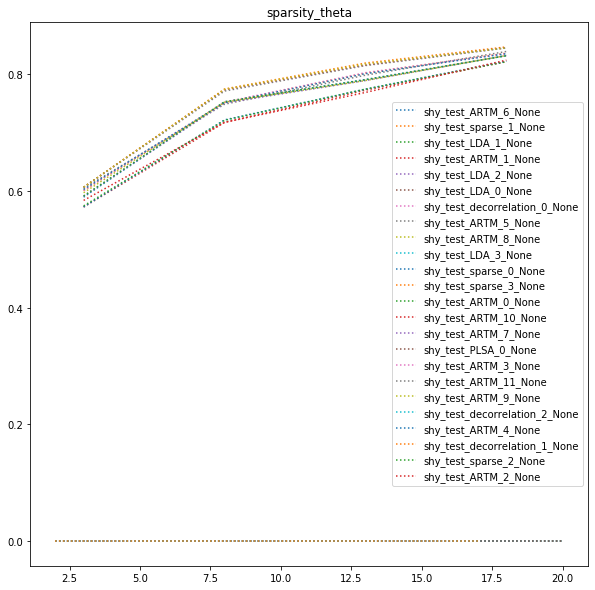

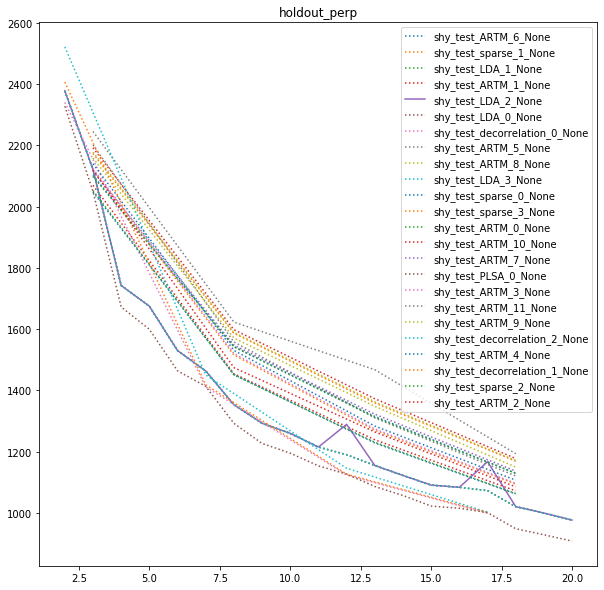

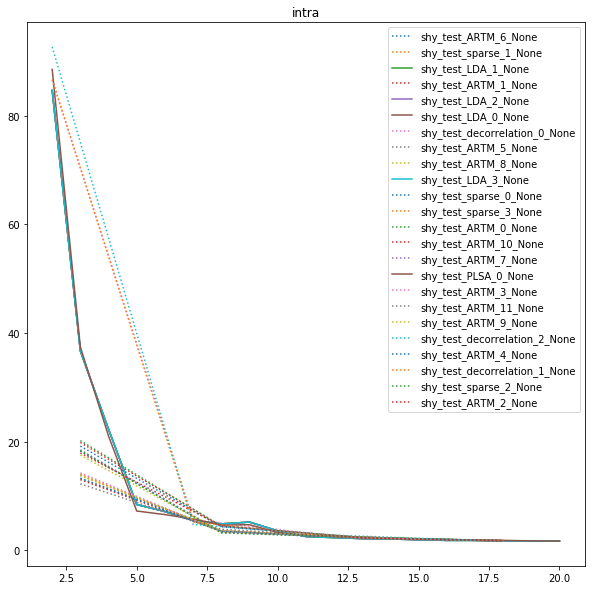

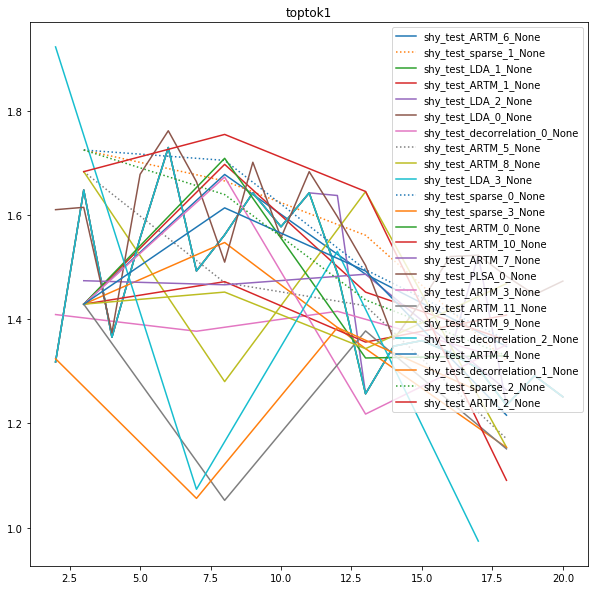

In [49]:
plot_everything_informative(experiment_directory, experiment_name_template, [], 
                            ["diversity", "_sparsity", 'renyi', 'arun', 'calhar', 'silh'])
